In [3]:
import torch
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import torchvision
import torchvision.models as models
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST

from captum.attr import visualization as viz

import numpy as np
import scipy
from scipy.linalg import orth

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pandas as pd

from copy import deepcopy
from tqdm import tqdm
import pickle as pkl
import os
import random

from scipy import ndimage as ndi
from skimage.util import random_noise
from skimage import feature

# our own imports
import util
from util import compute_tangent_space, project_into_tangent_space, normalize_image, dcn

from models import lenet_model_and_optimizer

from SyntheticMNIST import SyntheticMNIST, SyntheticMNIST256

%load_ext autoreload
%autoreload 2

In [ ]:
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent
from easydict import EasyDict

In [5]:
def fgsm(model, X, y, epsilon=0.1):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = torch.zeros_like(X, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(X + delta), y)
    loss.backward()
    return epsilon * delta.grad.detach().sign()

def pgd_linf(model, X, y, epsilon=0.1, alpha=0.01, num_iter=20, randomize=False):
    """ Construct FGSM adversarial examples on the examples X"""
    if randomize:
        delta = torch.rand_like(X, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X, requires_grad=True)
        
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
        delta.grad.zero_()
    return delta.detach()

def pgd_l2(model, X, y, epsilon=[1., 4., 8.], num_iter=100):
    """ Construct FGSM adversarial examples on the examples X"""
    # randomly choose epsilon
    epsilon = np.random.choice(epsilon)
    
    # choose a random starting point with length epsilon / 2
    delta = torch.rand_like(X, requires_grad=True) 
    norm = torch.linalg.norm(delta.flatten())
    delta.data = epsilon * delta.data / norm / 2
    
    alpha = 2.5 * epsilon / num_iter # fixed step size of 2.5*epsilon/100 as in https://arxiv.org/pdf/1706.06083.pdf
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(X + delta), y)
        loss.backward()
        
        # take a step
        step = delta.grad.detach()
        step = alpha * step / torch.linalg.norm(step.flatten())  
        delta.data = delta.data + step
        
        # project on the epsilon ball around X if necessary
        norm = torch.linalg.norm(delta.flatten())
        if norm > epsilon:
            delta.data = epsilon * delta.data / norm
        
        # next iteration
        delta.grad.zero_()
    return delta.detach()

In [6]:
def cleverhans_eval_linf(net, testloader, eps):
    # Evaluate on clean and adversarial data
    net.eval()
    report = EasyDict(nb_test=0, correct=0, correct_fgm=0, correct_pgd=0)
    for x, y in testloader:
        x, y = x.to(device), y.to(device)
        x_fgm = fast_gradient_method(net, x, eps, np.inf)
        x_pgd = projected_gradient_descent(net, x, eps, 0.01, 40, np.inf)
        _, y_pred = net(x).max(1)  # model prediction on clean examples
        _, y_pred_fgm = net(x_fgm).max(
                1
        )  # model prediction on FGM adversarial examples
        _, y_pred_pgd = net(x_pgd).max(
                1
        )  # model prediction on PGD adversarial examples
        report.nb_test += y.size(0)
        report.correct += y_pred.eq(y).sum().item()
        report.correct_fgm += y_pred_fgm.eq(y).sum().item()
        report.correct_pgd += y_pred_pgd.eq(y).sum().item()
    print(
        "test acc on clean examples (%): {:.3f}".format(
            report.correct / report.nb_test * 100.0
        )
    )
    print(
        "test acc on FGM adversarial examples (%): {:.3f}".format(
            report.correct_fgm / report.nb_test * 100.0
        )
    )
    print(
        "test acc on PGD adversarial examples (%): {:.3f}".format(
            report.correct_pgd / report.nb_test * 100.0
        )
    )
    
def cleverhans_eval_l2(net, testloader, eps):
    # Evaluate on clean and adversarial data
    net.eval()
    report = EasyDict(nb_test=0, correct=0, correct_fgm=0, correct_pgd=0)
    for x, y in testloader:
        x, y = x.to(device), y.to(device)
        x_fgm = fast_gradient_method(net, x, eps, 2)
        x_pgd = projected_gradient_descent(net, x, eps, 2.5*eps/100, 100, 2)
        _, y_pred = net(x).max(1)  # model prediction on clean examples
        _, y_pred_fgm = net(x_fgm).max(
                1
        )  # model prediction on FGM adversarial examples
        _, y_pred_pgd = net(x_pgd).max(
                1
        )  # model prediction on PGD adversarial examples
        report.nb_test += y.size(0)
        report.correct += y_pred.eq(y).sum().item()
        report.correct_fgm += y_pred_fgm.eq(y).sum().item()
        report.correct_pgd += y_pred_pgd.eq(y).sum().item()
    print(
        "test acc on clean examples (%): {:.3f}".format(
            report.correct / report.nb_test * 100.0
        )
    )
    print(
        "test acc on FGM adversarial examples (%): {:.3f}".format(
            report.correct_fgm / report.nb_test * 100.0
        )
    )
    print(
        "test acc on PGD adversarial examples (%): {:.3f}".format(
            report.correct_pgd / report.nb_test * 100.0
        )
    )
    return 1 - report.correct_pgd / report.nb_test

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(device)

cuda


In [8]:
IMG_DIM = 32

In [9]:
z_monitor, x_monitor, c_monitor, t_monitor = pkl.load(open('/mnt/qb/luxburg/sbordt10/explanations-manifold/output/mnist_monitor_32_10000.pkl', 'rb'))
print(len(t_monitor))

10000


In [11]:
z_monitor, x_monitor, c_monitor, t_monitor = pkl.load(open('./output/mnist_monitor_32_1000.pkl', 'rb'))
print(len(t_monitor))

1000


## data

In [7]:
trainset = torch.utils.data.TensorDataset(*torch.load('./data/MNIST32_train.pkl'))
trainloader = DataLoader(trainset, batch_size=100, shuffle=True) # same batchsize as in example

testset = torch.utils.data.TensorDataset(*torch.load('./data/MNIST32_val.pkl'))
testloader = DataLoader(testset, batch_size=100, shuffle=True)

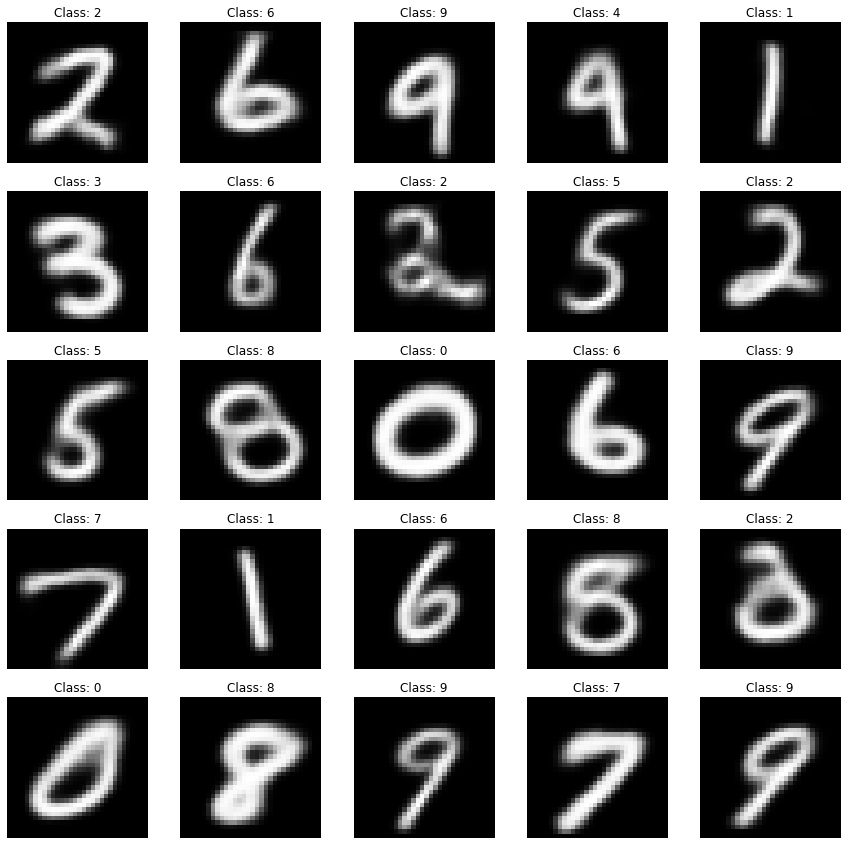

In [8]:
fix, axs = plt.subplots(5, 5, figsize=(15, 15))
for i in range(5):
    for j in range(5):
        img, c = iter(trainloader).__next__()
        axs[i,j].imshow(dcn(img[0, 0, :, :]), cmap='gray', interpolation='none')
        axs[i,j].set_title(f'Class: {c[0]}')
        axs[i,j].axis('off')
plt.show()

## Adversarially robust training

#### monitor how class gradients evolve during training

In [11]:
def model_and_optimizer():
    return lenet_model_and_optimizer(lr=1e-1)
model, _ = model_and_optimizer()
optimizer = optim.SGD(model.parameters(), lr=1e-1)
model.to(device)

MNIST32Model(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=12544, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [15]:
gradient_steps_to_monitor = list(range(21))
gradient_steps_to_monitor.extend([25*i for i in range(1, 25)])
gradient_steps_to_monitor.extend([600 + 100*i for i in range(1, 15)])
gradient_steps_to_monitor.extend([2000 + 1000*i for i in range(1, 100)])

In [16]:
# decrease the learning rate after 4 epochs
scheduler = MultiStepLR(optimizer, milestones=[4], gamma=0.1)

In [17]:
N = 250 # size of evaluation dataset
inputs = [x_monitor[i, :, :, :] for i in range(N)]
model.to(device)
ce_loss = torch.nn.CrossEntropyLoss()
num_gradient_steps = 0
gradient_step_monitoring = {}

for i_epoch in range(15):    
    print(f' --- Epoch {i_epoch} --- ')
    # gradient descent on the dataset
    ce_loss = torch.nn.CrossEntropyLoss()
    model.train()
    train_loss = 0
    train_zero_one_loss = 0
    for img, label in trainloader:
        # monitoring
        if num_gradient_steps in gradient_steps_to_monitor: 
            print(f'Monitoring after {num_gradient_steps} gradient steps.')
            grad_list, int_grad_list, igx_list = util.compute_saliency_maps(model, inputs)
            smooth_grad_list = [util.smooth_grad(model, img, 0.02, 25) for img in inputs]
            # compute and store fractions
            test_zero_one_loss = util.test(model, testloader, device, verbose=False)
            adv_test_zero_one_loss = cleverhans_eval_l2(model, testloader, 1)
            # TODO aversarial test loss
            frac_grad_its = util.tangent_space_ratio(grad_list, t_monitor[:N])
            frac_smooth_grad_its = util.tangent_space_ratio(smooth_grad_list, t_monitor[:N])
            frac_int_grad_its = util.tangent_space_ratio(int_grad_list, t_monitor[:N]) 
            frac_ixg_its = util.tangent_space_ratio(igx_list, t_monitor[:N])
            gradient_step_monitoring[num_gradient_steps] = [np.mean(frac_grad_its), 
                                                            np.mean(frac_smooth_grad_its), 
                                                            np.mean(frac_int_grad_its), 
                                                            np.mean(frac_ixg_its),
                                                            test_zero_one_loss,
                                                            adv_test_zero_one_loss]
            # resume training 
            model.train()
            
        # take a single gradient step
        img, label = img.to(device), label.to(device)
        
        delta = pgd_l2(model, img, label) # adversarial perturbation
        
        pred = model(img + delta)
        optimizer.zero_grad()
        loss = ce_loss(pred, label)
        loss.backward()
        train_loss += loss.item()  
        train_zero_one_loss += (pred.softmax(dim=1).argmax(dim=1) != label).sum().item()
        optimizer.step()
        num_gradient_steps += 1
    train_zero_one_loss = train_zero_one_loss / len(trainloader.dataset)
    print('Train Error: ', train_zero_one_loss)
    
    util.test(model, testloader, device)
    scheduler.step()

9it [00:00, 82.61it/s]

 --- Epoch 0 --- 
Monitoring after 0 gradient steps.


250it [00:02, 86.01it/s]


test acc on clean examples (%): 11.150
test acc on FGM adversarial examples (%): 8.670
test acc on PGD adversarial examples (%): 8.180


9it [00:00, 89.09it/s]

Monitoring after 1 gradient steps.


250it [00:02, 87.48it/s]


KeyboardInterrupt: 

In [ ]:
torch.save(gradient_step_monitoring, f'./output/mnist32_adversarial_gradient_step_monitoring_{aid}')
torch.save(model.state_dict(), f'./models/mnist_32_adv_robust_l2_v2_{aid}.pth')

In [ ]:
for epsilon in [0.5, 1, 2, 4, 8, 10, 20]:
    print(f' --------- {epsilon} --------- ')
    cleverhans_eval_l2(model, testloader, epsilon)